 Практика. Часть 2

DQN для задачи FrozenLake

В Deep Q-Learning наша цель — аппроксимировать исходную Q-таблицу с помощью функции, представляющей собой «чёрный ящик». Использовать будем простую нейронную сеть. На входе функция будет получать состояние, на выходе — вектор, каждый элемент которого будет соответствовать потенциальным действиям.



https://lms-cdn.skillfactory.ru/assets/courseware/v1/f4d6db7406bcd9326278033924f03f7b/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/DL_11_модуль_34.png

Задаём модель в блоке DQN Model.
Подготавливаем обучение.

https://lms-cdn.skillfactory.ru/assets/courseware/v1/deece8a7408b1d7711987404c2a1fb4d/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/DL_11_модуль_31.png

Рассмотрим и запустим цикл обучения в блоке DQN training. Этапы обучения остаются теми же.
Ознакомимся с визуализацией траекторий в следующих блоках.
Запускаем симуляцию.
В этом Deep Q-Learning мы упустили некоторые фишки, например, experience replay (replay-буфер). Далее мы рассмотрим ещё один пример без experience replay. В Домашнем задании к модулю вам предстоит реализовать experience replay, чтобы улучшить качество следующей задачи.

In [1]:
import numpy as np
import random

import gym

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.16.2


In [3]:
env = gym.make('FrozenLake-v1', is_slippery=False)
s = env.reset()

NUM_STATES = env.observation_space.n
NUM_ACTIONS = env.action_space.n

print('States: {}'.format(NUM_STATES))
print('Actions: {}'.format(NUM_ACTIONS))

States: 16
Actions: 4


In [4]:
LR = 0.1
gamma = 0.99

NUM_EPISODES = 20
MAX_STEPS = 100
REWARD_AVERAGE_WINDOW = 20

In [5]:
model = M.Sequential([L.Dense(
    NUM_ACTIONS,
    activation=None,
    use_bias=False,
    kernel_initializer=tf.random_uniform_initializer(0, 0.01))])

def evalQ(s):
     return model(tf.one_hot([s], NUM_STATES)).numpy()[0]

In [6]:
evalQ(0)


2025-03-10 22:00:09.829254: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-10 22:00:09.829285: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-10 22:00:09.829291: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-10 22:00:09.829333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-10 22:00:09.829348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


array([0.00039755, 0.00432806, 0.00468884, 0.00349538], dtype=float32)

In [7]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer)

pathLenList = []
totalRewardList = []
totalRewardAverageList = []

In [9]:
for i in range(NUM_EPISODES):
    
    eps = 1. / ((i / 50) + 10)
    
    s, _ = env.reset()  # Учитываем, что reset() теперь возвращает кортеж
    s = int(s)  # Приводим к int
    
    totalReward = 0
    step = 0
    
    while step < MAX_STEPS:
        step += 1
        print("s", s)
        
        Q_s = evalQ(s)
        print("Q_s = evalQ(s)   ", Q_s) 
        
        if np.random.rand() < eps:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q_s)

        print("a ", a)

        s1, r, done, _, _ = env.step(a)  # Учитываем, что step() теперь возвращает 5 значений
        s1 = int(s1)  # Приводим к int
        print("s1 ", s1)
        
        Q_s1 = evalQ(s1)
        Q_target = Q_s.copy()  # Создаём копию, чтобы не изменять исходный Q_s

        print("Q_target ", Q_target)
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
        
        Q_target = tf.constant(Q_target, dtype=tf.float32)[None, ...]  # Приводим к правильному типу
        print("Q_target ", Q_target)

        model.train_on_batch(tf.one_hot([s], NUM_STATES, dtype=tf.float32), Q_target)

        totalReward += r
        s = s1
        
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)

    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))


s 0
Q_s = evalQ(s)    [0.00039755 0.00432806 0.00468884 0.00349538]
a  0
s1  0
Q_target  [0.00039755 0.00432806 0.00468884 0.00349538]
Q_target  tf.Tensor([[0.00464195 0.00432806 0.00468884 0.00349538]], shape=(1, 4), dtype=float32)


/Users/apple/python/SkillFactory/Ml_learning/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
2025-03-10 22:01:23.503154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


s 0
Q_s = evalQ(s)    [0.00124643 0.00432806 0.00468884 0.00349538]
a  2
s1  1
Q_target  [0.00124643 0.00432806 0.00468884 0.00349538]
Q_target  tf.Tensor([[0.00124643 0.00432806 0.00933708 0.00349538]], shape=(1, 4), dtype=float32)
s 1
Q_s = evalQ(s)    [0.00722187 0.00537051 0.00943139 0.00179858]
a  2
s1  2
Q_target  [0.00722187 0.00537051 0.00943139 0.00179858]
Q_target  tf.Tensor([[0.00722187 0.00537051 0.00546721 0.00179858]], shape=(1, 4), dtype=float32)
s 2
Q_s = evalQ(s)    [0.00382008 0.00104905 0.00552243 0.00525312]
a  2
s1  3
Q_target  [0.00382008 0.00104905 0.00552243 0.00525312]
Q_target  tf.Tensor([[0.00382008 0.00104905 0.00890581 0.00525312]], shape=(1, 4), dtype=float32)
s 3
Q_s = evalQ(s)    [0.00017954 0.00125602 0.00899576 0.00502548]
a  2
s1  3
Q_target  [0.00017954 0.00125602 0.00899576 0.00502548]
Q_target  tf.Tensor([[0.00017954 0.00125602 0.00890581 0.00502548]], shape=(1, 4), dtype=float32)
s 3
Q_s = evalQ(s)    [0.00017954 0.00125602 0.00897777 0.00502548]


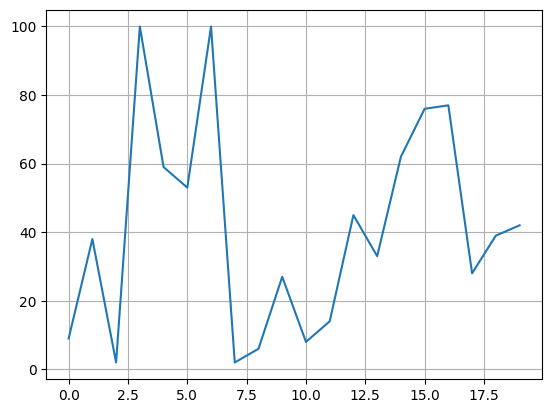

In [10]:
plt.plot(pathLenList)
plt.grid()

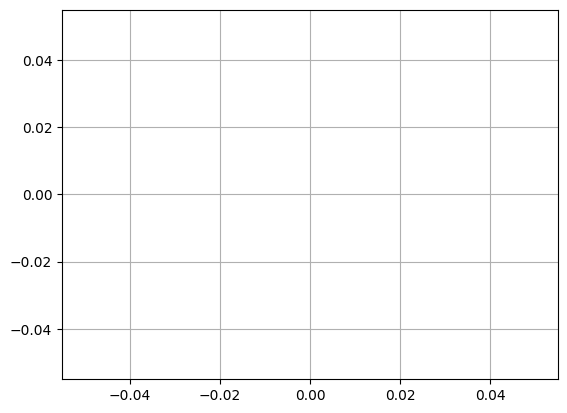

In [11]:
plt.plot(totalRewardAverageList)
plt.grid()

In [12]:
s = env.reset()

for _ in range(1000):
    env.render()
    a = np.argmax(evalQ(s))
    s, r, done, _ = env.step(a)
    if done:
        env.render()
        print('Reward = {}'.format(r))
        break
        
env.close()

/Users/apple/python/SkillFactory/Ml_learning/venv/lib/python3.10/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


ValueError: Can't convert Python sequence with mixed types to Tensor.